# Convolutional VAE for MNIST

This notebook implements a variational autoencoder that uses convolutional layers for feature extraction (instead of fully connected layers). We use the model to generate images of handwritten digits.

In [1]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Get data

# Training Set
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

# Test set
test_dataset = datasets.MNIST(root='data',
                               train=False,
                               transform=transforms.ToTensor(),
                               download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110343329.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111440380.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44957722.41it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16213215.97it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# Set up hyperparameters and device

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
random_seed = 42
lr = 0.005
epochs = 50
batch_size = 256

# Check
print(f'We are using {device} to train our model.')

We are using cuda to train our model.


In [5]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=False)

In [6]:
print(f'We have split the training set to {len(train_loader)} batches.')

We have split the training set to 235 batches.


In [7]:
print('Training Set:\n')
for images,labels in train_loader:
  print('Image batch dimensions:', images.size())
  print('Image label dimensions:', labels.size())
  break


print('\nTest Set:\n')
for images,labels in test_loader:
  print('Image batch dimensions:', images.size())
  print('Image label dimensions:', labels.size())
  break



Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])

Test Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [8]:
# Model Definition

# This is a helper class
class Reshape(nn.Module):
  def __init__(self,*args):
    super().__init__()
    self.shape = args

  def forward(self,x):
    return x.view(self.shape)

# This is also a helper class
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

# Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(3136, 2) # Latent space is 2d for visualisation purposes
        self.z_log_var = torch.nn.Linear(3136, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded


In [9]:
# Initialize model

torch.manual_seed(random_seed)
model = VAE()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [10]:
# Model summary
!pip install torchinfo

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       18,496
│    └─LeakyReLU: 2-4                    --
│    └─Conv2d: 2-5                       36,928
│    └─LeakyReLU: 2-6                    --
│    └─Conv2d: 2-7                       36,928
│    └─Flatten: 2-8                      --
├─Linear: 1-2                            6,274
├─Linear: 1-3                            6,274
├─Sequential: 1-4                        --
│    └─Linear: 2-9                       9,408
│    └─Reshape: 2-10                     --
│    └─ConvTranspose2d: 2-11             36,928
│    └─LeakyReLU: 2-12                   --
│    └─ConvTranspose2d: 2-13             36,928
│    └─LeakyReLU: 2-14                   --
│    └─ConvTranspose2d: 2-15             18,464
│    └─LeakyReLU: 2-16               

In [11]:
import time
import torch.nn.functional as F


def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def train_vae_v1(num_epochs, model, optimizer, device,
                 train_loader, loss_fn=None,
                 logging_interval=100,
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):

    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)

            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 +
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var
                                      - z_mean**2
                                      - torch.exp(z_log_var),
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension

            loss = reconstruction_term_weight*pixelwise + kl_div

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [12]:
log_dict = train_vae_v1(num_epochs=epochs, model=model,
                        optimizer=optimizer, device=device,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0235 | Loss: 184.0030
Epoch: 001/050 | Batch 0050/0235 | Loss: 52.6648
Epoch: 001/050 | Batch 0100/0235 | Loss: 48.2810
Epoch: 001/050 | Batch 0150/0235 | Loss: 46.8258
Epoch: 001/050 | Batch 0200/0235 | Loss: 44.4237
Time elapsed: 0.22 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 43.5128
Epoch: 002/050 | Batch 0050/0235 | Loss: 42.4147
Epoch: 002/050 | Batch 0100/0235 | Loss: 41.2051
Epoch: 002/050 | Batch 0150/0235 | Loss: 41.5819
Epoch: 002/050 | Batch 0200/0235 | Loss: 39.9492
Time elapsed: 0.37 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 42.3501
Epoch: 003/050 | Batch 0050/0235 | Loss: 40.3952
Epoch: 003/050 | Batch 0100/0235 | Loss: 40.5175
Epoch: 003/050 | Batch 0150/0235 | Loss: 41.4761
Epoch: 003/050 | Batch 0200/0235 | Loss: 41.5170
Time elapsed: 0.49 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 39.0592
Epoch: 004/050 | Batch 0050/0235 | Loss: 41.0667
Epoch: 004/050 | Batch 0100/0235 | Loss: 38.0776
Epoch: 004/050 | Batch 0150/0235 | Loss: 41.2722

In [14]:
import numpy as np

def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

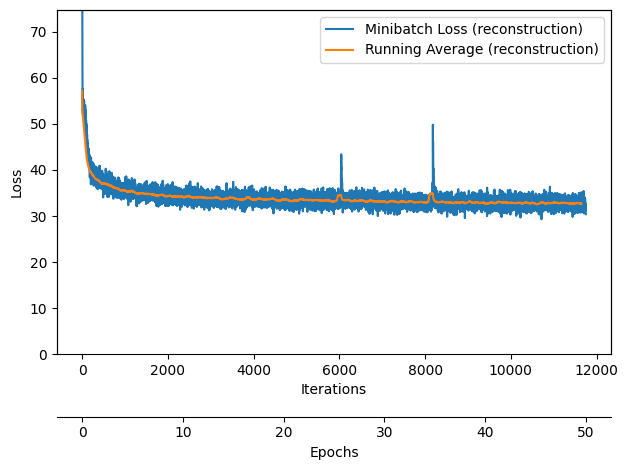

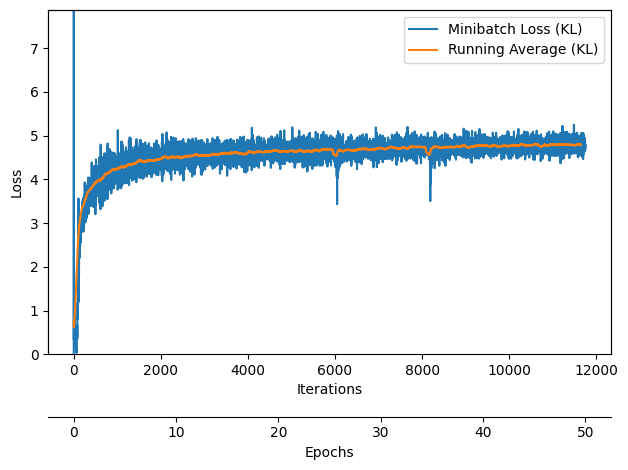

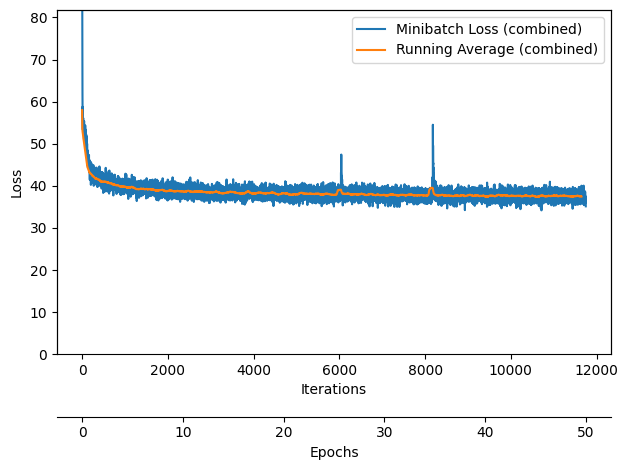

In [16]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], epochs, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], epochs, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], epochs, custom_label=" (combined)")
plt.show()

In [17]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

In [21]:
import matplotlib.colors as mcolors

def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

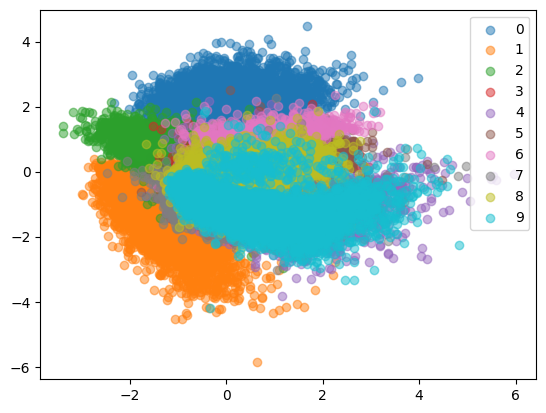

In [22]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn,
    device=device)

plt.legend()
plt.show()

In [23]:
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary')

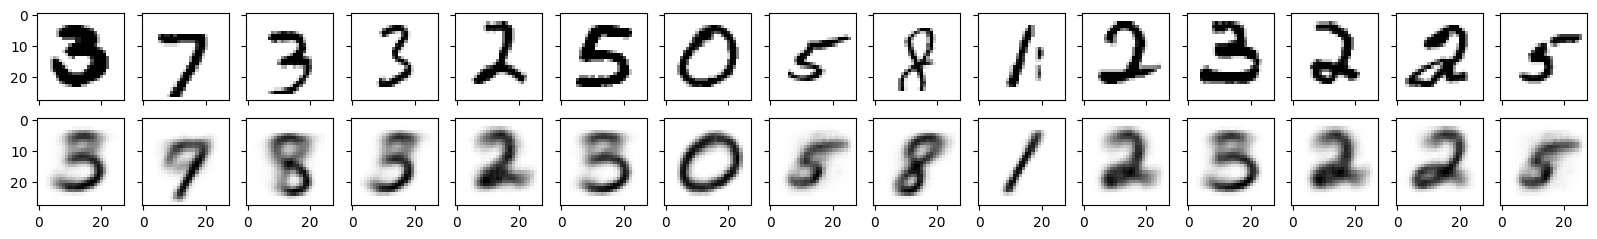

In [24]:
plot_generated_images(data_loader=train_loader, model=model, device=device, modeltype='VAE')